In [19]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy import special
from scipy.spatial import distance
import seaborn as sns
from sklearn import metrics
import tqdm

from scripture_graph import graph_lib

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
digraph = nx.read_graphml('../../../scripture_graph.graphml')
print(digraph.number_of_nodes(), digraph.number_of_edges())
graph_lib.remove_topic_nodes(digraph)
print(digraph.number_of_nodes(), digraph.number_of_edges())
graph = digraph.to_undirected()
print(graph.number_of_nodes(), graph.number_of_edges())

48566 183072
41995 45985
41995 26946


In [3]:
# nx.jaccard_coefficient is too slow; we can roll our own with the adjacency matrix.
possible = special.comb(graph.number_of_nodes(), 2, exact=True) - graph.number_of_nodes()
print(graph.number_of_edges(), possible, graph.number_of_edges() / possible * 100)

26946 881727020 0.00305604789110353


In [4]:
a = nx.adjacency_matrix(graph)
type(a)

scipy.sparse.csr.csr_matrix

In [5]:
# What is the average number of connections?
total = a.sum(axis=1)
print(np.mean(total), np.median(total))
# now without the singletons
print(np.mean(total[total > 0]), np.median(total[total > 0]))

1.2832956304321943 [[ 0.  0.  0. ...  2. 11. 36.]]
2.7284325637910083 [[ 1.  1.  1. ...  2. 11. 36.]]


In [6]:
# scipy jaccard sets the distance to zero when there are no common neighbors
def jaccard(a):
    ab = a @ a.T
    aa = a.sum(axis=1)
    bb = aa.T
    return ab / (aa + bb - ab)

In [7]:
%%time
s = jaccard(a)
s = np.nan_to_num(s, copy=False)
s[np.diag_indices_from(s)] = 0
print(s.shape)

/home/kearnes/miniconda3/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


(41995, 41995)
CPU times: user 13.4 s, sys: 6.35 s, total: 19.7 s
Wall time: 19.8 s


In [9]:
print(nz.shape, (nz > 0).sum())

(881769015,) 95247


In [44]:
%%time
nodes = np.asarray(graph.nodes())
mask = np.where(s > 0)
rows = []
for i, j in zip(*mask):
    order = sorted([nodes[i], nodes[j]])
    a = set([n[1] for n in graph.edges(order[0])])
    b = set([n[1] for n in graph.edges(order[1])])
    rows.append({
        'a': order[0], 
        'b': order[1], 
        'jaccard': s[i, j], 
        'intersection': len(a & b), 
        'union': len(a | b),
    })
df = pd.DataFrame(rows)
print(df.shape)
df = df.drop_duplicates(['a', 'b'])
print(df.shape)
df.head()

(190494, 5)
(95247, 5)
CPU times: user 5.99 s, sys: 126 ms, total: 6.11 s
Wall time: 6.11 s


,a,b,jaccard,intersection,union
0,1 Chr. 1:3,Moses 7:52,0.333333,1,3
1,1 Chr. 1:4,1 Chr. 1:8,0.500000,1,2
2,1 Chr. 1:4,Gen. 5:32,0.166667,1,6
3,1 Chr. 1:4,Gen. 8:16,0.333333,1,3
4,1 Chr. 1:4,Gen. 9:18,0.333333,1,3


In [34]:
df.shape[0] / possible * 100

0.010802322923028943

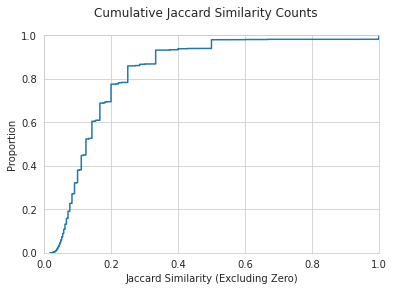

In [37]:
sns.set_style('whitegrid')
fig, ax = subplots()
sns.ecdfplot(data=df, x='jaccard', ax=ax)
suptitle('Cumulative Jaccard Similarity Counts')
ax.set_xlabel('Jaccard Similarity (Excluding Zero)')
ax.set_xlim(0, 1)
fig.savefig('jaccard-cdf.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='intersection', ylabel='jaccard'>

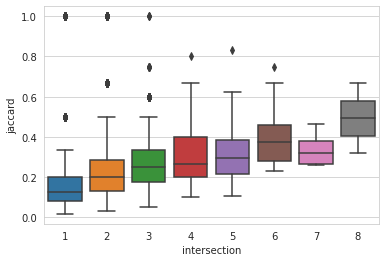

In [53]:
sns.boxplot(data=df, x='intersection', y='jaccard')

In [1]:
sns.boxplot(data=df, x='intersection', y='union')

NameError: name 'sns' is not defined

In [57]:
df.sort_values('intersection', ascending=False)

,a,b,jaccard,intersection,union
136840,D&C 18:26,D&C 90:9,0.666667,8,12
124485,D&C 101:7,Mosiah 21:15,0.320000,8,25
156269,D&C 8:3,Mosiah 7:19,0.259259,7,27
104998,3 Ne. 25:1,D&C 29:9,0.269231,7,26
126913,D&C 107:33,D&C 19:27,0.333333,7,21
...,...,...,...,...,...
39270,Alma 41:11,Isa. 26:11,0.142857,1,7
39269,Alma 11:39,Isa. 26:11,0.076923,1,13
39268,2 Ne. 26:12,Isa. 26:11,0.066667,1,15
39267,1 Ne. 19:10,Isa. 26:11,0.027778,1,36


In [56]:
df.sort_values('union', ascending=False)

,a,b,jaccard,intersection,union
86512,1 Ne. 19:10,2 Ne. 25:20,0.033898,2,59
81230,1 Ne. 19:10,1 Ne. 1:4,0.017544,1,57
86606,1 Ne. 19:10,Mosiah 7:19,0.053571,3,56
86517,1 Ne. 19:10,2 Ne. 31:21,0.018868,1,53
86601,1 Ne. 19:10,Mosiah 3:5,0.038462,2,52
...,...,...,...,...,...
93006,2 Ne. 21:6,2 Ne. 30:12,1.000000,1,1
166668,Hel. 1:30,Hel. 4:8,1.000000,1,1
166669,Hel. 11:24,Hel. 1:32,1.000000,1,1
143866,D&C 41:3,D&C 58:23,1.000000,1,1


In [45]:
df.sort_values('jaccard', ascending=False)

,a,b,jaccard,intersection,union
105942,3 Ne. 28:15,Ether 3:8,1.000000,1,1
19586,3 Ne. 28:35,Deut. 8:11,1.000000,1,1
5224,1 Sam. 12:24,Neh. 12:43,1.000000,1,1
43424,2 Ne. 18:17,Isa. 64:7,1.000000,1,1
43519,Isa. 65:10,Josh. 7:26,1.000000,1,1
...,...,...,...,...,...
81914,1 Ne. 10:12,1 Ne. 19:10,0.020000,1,50
136483,D&C 17:1,Mosiah 7:19,0.020000,1,50
86555,1 Ne. 19:10,D&C 19:27,0.019608,1,51
86517,1 Ne. 19:10,2 Ne. 31:21,0.018868,1,53


In [47]:
df[df.jaccard == 1].sort_values('intersection', ascending=False)

,a,b,jaccard,intersection,union
19103,Deut. 5:17,Matt. 5:21,1.0,3,3
9028,2 Kgs. 14:24,2 Kgs. 15:9,1.0,3,3
43815,2 Ne. 18:6,Isa. 8:6,1.0,3,3
39001,D&C 88:105,Isa. 21:9,1.0,2,2
31356,1 Ne. 20:10,Gen. 15:13,1.0,2,2
...,...,...,...,...,...
20796,Esth. 5:9,Prov. 27:3,1.0,1,1
20795,Esth. 5:6,Esth. 9:12,1.0,1,1
20794,Esth. 5:2,Esth. 8:4,1.0,1,1
20777,Alma 47:22,Esth. 3:2,1.0,1,1


In [51]:
df[df.jaccard == 1].intersection.value_counts()

1    1689
2      31
3       3
Name: intersection, dtype: int64

In [33]:
# singletons: no outgoing or incoming edges
num_singletons = 0
for node in graph.nodes:
    if not graph.edges(node):
        num_singletons += 1
print(num_singletons, graph.number_of_nodes(), num_singletons / graph.number_of_nodes())

22243 41995 0.5296582926538874
